In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
# Hyperparameters

# input_dim = 1      # Number of features in the input data
# hidden_dim = 32     # Number of hidden units in the LSTM
# num_layers = 2       # Number of LSTM layers
# output_dim = 1      # Number of output units (e.g., regression output)
# num_epochs = 500
# batch_size = 64
# lr = 0.01
# seq_length = 30  # Length of the input sequences

In [3]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Coletar os dados para treino
symbol = 'PETR4.SA'
start_date = '2020-01-01'
end_date = '2025-05-30'
df = yf.download(symbol, start_date, end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

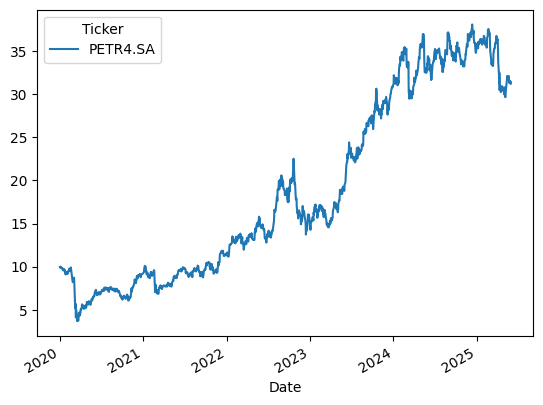

In [4]:
# Ordenar por data
df = df.sort_values('Date')
df.Close.plot()
# df['Close']

In [5]:
# Preparar os Dados#
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
# df['Close']
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)
train_size = int(0.8 * len(data))

x_train = torch.from_numpy(
    data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(
    data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(
    data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(
    data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [6]:
# Treinar Modelo


class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


model = PredictionModel(input_dim=1, hidden_dim=32,
                        num_layers=2, output_dim=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500

for i in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

0 0.616546630859375
25 0.008013583719730377
50 0.002803581301122904
75 0.0023049204610288143
100 0.0021314374171197414
125 0.0020219022408127785
150 0.0019457106245681643
175 0.0018862700089812279
200 0.0018344959244132042
225 0.0017869456205517054
250 0.0017423097742721438
275 0.0016999015351757407
300 0.0016592807369306684
325 0.0016201486578211188
350 0.0015822966815903783
375 0.0015455848770216107
400 0.001509927213191986
425 0.00147529155947268
450 0.0014417065540328622
475 0.001409280695952475


In [7]:
# Avaliar Modelo

#RMSE (Erro Quadrático Médio) - Penaliza mais fortemente grandes erros.

train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

print(train_rmse)
print(test_rmse)

0.397901713848114
0.5495619177818298


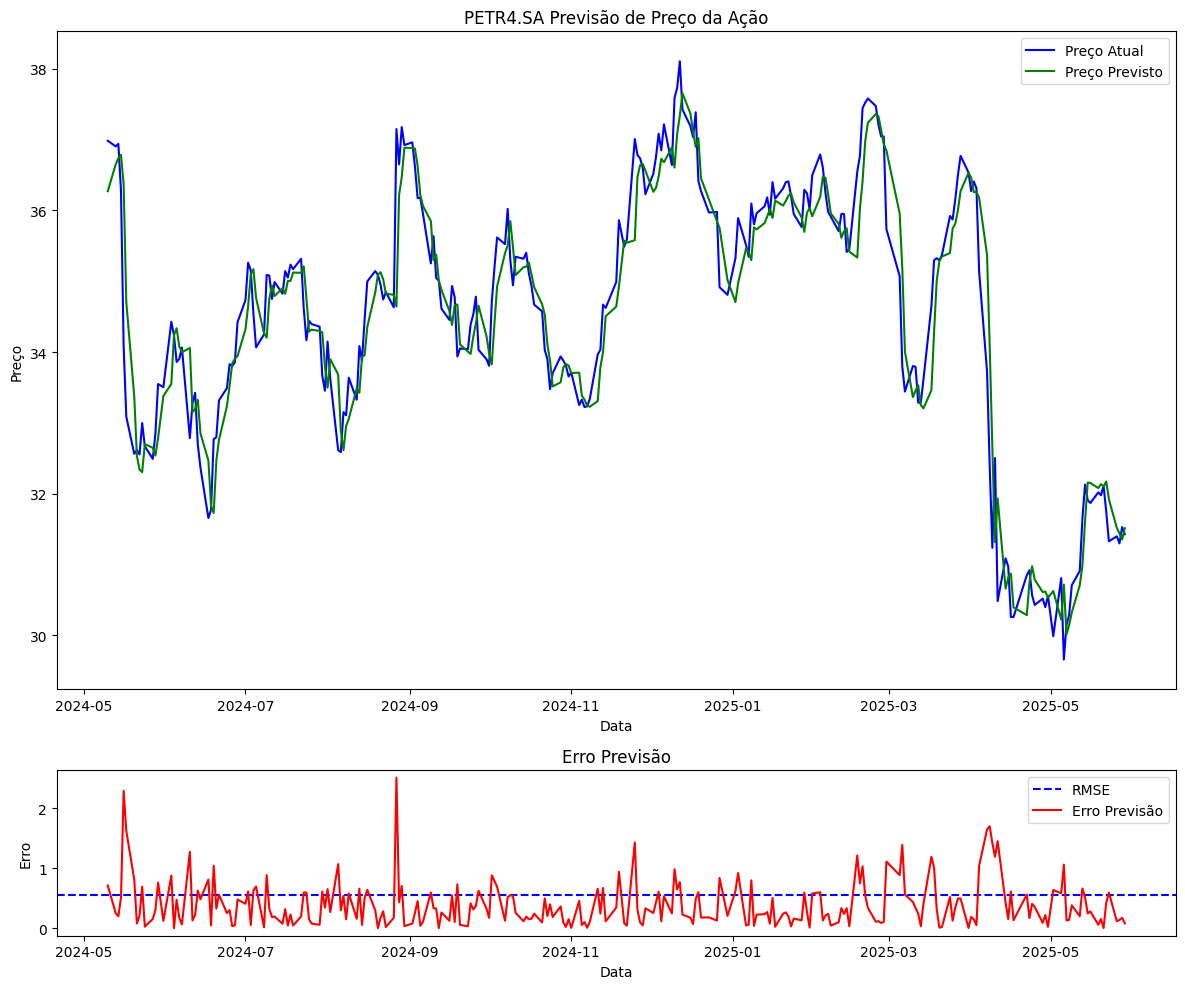

In [8]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test,
         color='blue', label='Preço Atual')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred,
         color='green', label='Preço Previsto')
ax1.legend()
plt.title(f"{symbol} Previsão de Preço da Ação")
plt.xlabel("Data")
plt.ylabel("Preço")

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test -
         y_test_pred), 'r', label='Erro Previsão')
ax2.legend()
plt.title('Erro Previsão')
plt.xlabel("Data")
plt.ylabel("Erro")
plt.tight_layout()
plt.show()